In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b10_b25_b50_b75_t1_mask_t1t2_normalized_k5_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 460)
(772408, 8)
validation
(101248, 460)
(101248, 8)
test
(98888, 460)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 460)]             0         


 dense (Dense)               (None, 1024)              472064    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1162120 (4.43 MB)


Trainable params: 1162120 (4.43 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:31 - loss: 2.6795 - STD: 0.0881 - MAE: 0.2287

 5/78 [>.............................] - ETA: 1s - loss: 1.8892 - STD: 0.1000 - MAE: 0.1961  

 9/78 [==>...........................] - ETA: 0s - loss: 1.6614 - STD: 0.1557 - MAE: 0.1682

13/78 [====>.........................] - ETA: 0s - loss: 1.5704 - STD: 0.1800 - MAE: 0.1563

18/78 [=====>........................] - ETA: 0s - loss: 1.5112 - STD: 0.1855 - MAE: 0.1526

23/78 [=======>......................] - ETA: 0s - loss: 1.4725 - STD: 0.1853 - MAE: 0.1517

28/78 [=========>....................] - ETA: 0s - loss: 1.4448 - STD: 0.1868 - MAE: 0.1503

33/78 [===========>..................] - ETA: 0s - loss: 1.4265 - STD: 0.1889 - MAE: 0.1491

36/78 [============>.................] - ETA: 1s - loss: 1.4197 - STD: 0.1896 - MAE: 0.1486

40/78 [==============>...............] - ETA: 1s - loss: 1.4097 - STD: 0.1898 - MAE: 0.1482

44/78 [===============>..............] - ETA: 0s - loss: 1.4015 - STD: 0.1897 - MAE: 0.1481

49/78 [=================>............] - ETA: 0s - loss: 1.3929 - STD: 0.1900 - MAE: 0.1478

53/78 [===================>..........] - ETA: 0s - loss: 1.3870 - STD: 0.1904 - MAE: 0.1475

58/78 [=====================>........] - ETA: 0s - loss: 1.3808 - STD: 0.1906 - MAE: 0.1473

63/78 [=======================>......] - ETA: 0s - loss: 1.3752 - STD: 0.1904 - MAE: 0.1472

68/78 [=========================>....] - ETA: 0s - loss: 1.3705 - STD: 0.1906 - MAE: 0.1470

73/78 [===========================>..] - ETA: 0s - loss: 1.3671 - STD: 0.1907 - MAE: 0.1469

78/78 [==============================] - ETA: 0s - loss: 1.3641 - STD: 0.1906 - MAE: 0.1469

78/78 [==============================] - 3s 29ms/step - loss: 1.3641 - STD: 0.1906 - MAE: 0.1469 - val_loss: 1.2749 - val_STD: 0.1895 - val_MAE: 0.1458


Epoch 2/10000


 1/78 [..............................] - ETA: 3s - loss: 1.3023 - STD: 0.1895 - MAE: 0.1454

 6/78 [=>............................] - ETA: 0s - loss: 1.3054 - STD: 0.1919 - MAE: 0.1446

11/78 [===>..........................] - ETA: 0s - loss: 1.3143 - STD: 0.1931 - MAE: 0.1447

16/78 [=====>........................] - ETA: 0s - loss: 1.3156 - STD: 0.1920 - MAE: 0.1451

21/78 [=======>......................] - ETA: 0s - loss: 1.3174 - STD: 0.1914 - MAE: 0.1455

26/78 [=========>....................] - ETA: 0s - loss: 1.3167 - STD: 0.1913 - MAE: 0.1455

31/78 [==========>...................] - ETA: 0s - loss: 1.3163 - STD: 0.1915 - MAE: 0.1454

36/78 [============>.................] - ETA: 0s - loss: 1.3164 - STD: 0.1917 - MAE: 0.1453

41/78 [==============>...............] - ETA: 0s - loss: 1.3164 - STD: 0.1915 - MAE: 0.1454

46/78 [================>.............] - ETA: 0s - loss: 1.3153 - STD: 0.1916 - MAE: 0.1453

50/78 [==================>...........] - ETA: 0s - loss: 1.3156 - STD: 0.1917 - MAE: 0.1453

55/78 [====================>.........] - ETA: 0s - loss: 1.3156 - STD: 0.1917 - MAE: 0.1453

60/78 [======================>.......] - ETA: 0s - loss: 1.3154 - STD: 0.1916 - MAE: 0.1453

65/78 [========================>.....] - ETA: 0s - loss: 1.3164 - STD: 0.1916 - MAE: 0.1454

70/78 [=========================>....] - ETA: 0s - loss: 1.3164 - STD: 0.1915 - MAE: 0.1454

75/78 [===========================>..] - ETA: 0s - loss: 1.3166 - STD: 0.1915 - MAE: 0.1454

78/78 [==============================] - 1s 14ms/step - loss: 1.3165 - STD: 0.1915 - MAE: 0.1454 - val_loss: 1.2742 - val_STD: 0.1913 - val_MAE: 0.1451


Epoch 3/10000


 1/78 [..............................] - ETA: 2s - loss: 1.3146 - STD: 0.1913 - MAE: 0.1454

 6/78 [=>............................] - ETA: 0s - loss: 1.3109 - STD: 0.1918 - MAE: 0.1451

11/78 [===>..........................] - ETA: 0s - loss: 1.3180 - STD: 0.1914 - MAE: 0.1456

16/78 [=====>........................] - ETA: 0s - loss: 1.3169 - STD: 0.1911 - MAE: 0.1456

21/78 [=======>......................] - ETA: 0s - loss: 1.3154 - STD: 0.1916 - MAE: 0.1453

26/78 [=========>....................] - ETA: 0s - loss: 1.3152 - STD: 0.1918 - MAE: 0.1453

31/78 [==========>...................] - ETA: 0s - loss: 1.3153 - STD: 0.1917 - MAE: 0.1453

36/78 [============>.................] - ETA: 0s - loss: 1.3167 - STD: 0.1916 - MAE: 0.1454

41/78 [==============>...............] - ETA: 0s - loss: 1.3162 - STD: 0.1915 - MAE: 0.1454

46/78 [================>.............] - ETA: 0s - loss: 1.3160 - STD: 0.1916 - MAE: 0.1454

51/78 [==================>...........] - ETA: 0s - loss: 1.3165 - STD: 0.1915 - MAE: 0.1454

56/78 [====================>.........] - ETA: 0s - loss: 1.3154 - STD: 0.1915 - MAE: 0.1453

61/78 [======================>.......] - ETA: 0s - loss: 1.3159 - STD: 0.1916 - MAE: 0.1454

66/78 [========================>.....] - ETA: 0s - loss: 1.3161 - STD: 0.1914 - MAE: 0.1455

71/78 [==========================>...] - ETA: 0s - loss: 1.3165 - STD: 0.1915 - MAE: 0.1455

76/78 [============================>.] - ETA: 0s - loss: 1.3164 - STD: 0.1914 - MAE: 0.1455

78/78 [==============================] - 1s 14ms/step - loss: 1.3165 - STD: 0.1914 - MAE: 0.1455 - val_loss: 1.2741 - val_STD: 0.1912 - val_MAE: 0.1451


Epoch 4/10000


 1/78 [..............................] - ETA: 3s - loss: 1.3139 - STD: 0.1912 - MAE: 0.1452

 5/78 [>.............................] - ETA: 0s - loss: 1.3105 - STD: 0.1921 - MAE: 0.1448

10/78 [==>...........................] - ETA: 0s - loss: 1.3138 - STD: 0.1924 - MAE: 0.1449

15/78 [====>.........................] - ETA: 0s - loss: 1.3170 - STD: 0.1916 - MAE: 0.1454

20/78 [======>.......................] - ETA: 0s - loss: 1.3164 - STD: 0.1916 - MAE: 0.1454

25/78 [========>.....................] - ETA: 0s - loss: 1.3172 - STD: 0.1917 - MAE: 0.1454

30/78 [==========>...................] - ETA: 0s - loss: 1.3172 - STD: 0.1913 - MAE: 0.1455

35/78 [============>.................] - ETA: 0s - loss: 1.3164 - STD: 0.1914 - MAE: 0.1454

40/78 [==============>...............] - ETA: 0s - loss: 1.3159 - STD: 0.1918 - MAE: 0.1452

45/78 [================>.............] - ETA: 0s - loss: 1.3155 - STD: 0.1917 - MAE: 0.1453

50/78 [==================>...........] - ETA: 0s - loss: 1.3163 - STD: 0.1917 - MAE: 0.1453

55/78 [====================>.........] - ETA: 0s - loss: 1.3157 - STD: 0.1916 - MAE: 0.1453

60/78 [======================>.......] - ETA: 0s - loss: 1.3161 - STD: 0.1916 - MAE: 0.1453

65/78 [========================>.....] - ETA: 0s - loss: 1.3163 - STD: 0.1916 - MAE: 0.1454

70/78 [=========================>....] - ETA: 0s - loss: 1.3159 - STD: 0.1915 - MAE: 0.1454

75/78 [===========================>..] - ETA: 0s - loss: 1.3161 - STD: 0.1916 - MAE: 0.1454

78/78 [==============================] - 1s 14ms/step - loss: 1.3165 - STD: 0.1915 - MAE: 0.1454 - val_loss: 1.2747 - val_STD: 0.1884 - val_MAE: 0.1462


Epoch 5/10000


 1/78 [..............................] - ETA: 3s - loss: 1.3276 - STD: 0.1884 - MAE: 0.1471

 6/78 [=>............................] - ETA: 0s - loss: 1.3163 - STD: 0.1907 - MAE: 0.1458

11/78 [===>..........................] - ETA: 0s - loss: 1.3179 - STD: 0.1916 - MAE: 0.1455

16/78 [=====>........................] - ETA: 0s - loss: 1.3159 - STD: 0.1908 - MAE: 0.1457

21/78 [=======>......................] - ETA: 0s - loss: 1.3173 - STD: 0.1914 - MAE: 0.1455

26/78 [=========>....................] - ETA: 0s - loss: 1.3176 - STD: 0.1911 - MAE: 0.1456

31/78 [==========>...................] - ETA: 0s - loss: 1.3177 - STD: 0.1912 - MAE: 0.1456

36/78 [============>.................] - ETA: 0s - loss: 1.3183 - STD: 0.1911 - MAE: 0.1456

41/78 [==============>...............] - ETA: 0s - loss: 1.3175 - STD: 0.1914 - MAE: 0.1455

46/78 [================>.............] - ETA: 0s - loss: 1.3170 - STD: 0.1912 - MAE: 0.1456

51/78 [==================>...........] - ETA: 0s - loss: 1.3169 - STD: 0.1914 - MAE: 0.1455

56/78 [====================>.........] - ETA: 0s - loss: 1.3164 - STD: 0.1913 - MAE: 0.1454

61/78 [======================>.......] - ETA: 0s - loss: 1.3163 - STD: 0.1914 - MAE: 0.1454

66/78 [========================>.....] - ETA: 0s - loss: 1.3161 - STD: 0.1914 - MAE: 0.1454

71/78 [==========================>...] - ETA: 0s - loss: 1.3158 - STD: 0.1914 - MAE: 0.1454

76/78 [============================>.] - ETA: 0s - loss: 1.3156 - STD: 0.1914 - MAE: 0.1454

78/78 [==============================] - 1s 14ms/step - loss: 1.3154 - STD: 0.1914 - MAE: 0.1454 - val_loss: 1.2673 - val_STD: 0.1925 - val_MAE: 0.1442


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 1.3115 - STD: 0.1929 - MAE: 0.1444

 6/78 [=>............................] - ETA: 0s - loss: 1.3066 - STD: 0.1918 - MAE: 0.1447

11/78 [===>..........................] - ETA: 0s - loss: 1.3041 - STD: 0.1917 - MAE: 0.1446

16/78 [=====>........................] - ETA: 0s - loss: 1.3039 - STD: 0.1916 - MAE: 0.1446

20/78 [======>.......................] - ETA: 0s - loss: 1.3034 - STD: 0.1914 - MAE: 0.1447

24/78 [========>.....................] - ETA: 0s - loss: 1.3028 - STD: 0.1915 - MAE: 0.1447

29/78 [==========>...................] - ETA: 0s - loss: 1.3021 - STD: 0.1916 - MAE: 0.1446

34/78 [============>.................] - ETA: 0s - loss: 1.3006 - STD: 0.1914 - MAE: 0.1445

38/78 [=============>................] - ETA: 0s - loss: 1.2975 - STD: 0.1919 - MAE: 0.1442

43/78 [===============>..............] - ETA: 0s - loss: 1.2948 - STD: 0.1925 - MAE: 0.1438

48/78 [=================>............] - ETA: 0s - loss: 1.2929 - STD: 0.1929 - MAE: 0.1436

53/78 [===================>..........] - ETA: 0s - loss: 1.2913 - STD: 0.1930 - MAE: 0.1435

58/78 [=====================>........] - ETA: 0s - loss: 1.2896 - STD: 0.1933 - MAE: 0.1433

63/78 [=======================>......] - ETA: 0s - loss: 1.2879 - STD: 0.1936 - MAE: 0.1431

68/78 [=========================>....] - ETA: 0s - loss: 1.2857 - STD: 0.1937 - MAE: 0.1430

73/78 [===========================>..] - ETA: 0s - loss: 1.2835 - STD: 0.1941 - MAE: 0.1428

78/78 [==============================] - ETA: 0s - loss: 1.2809 - STD: 0.1944 - MAE: 0.1427

78/78 [==============================] - 1s 14ms/step - loss: 1.2809 - STD: 0.1944 - MAE: 0.1427 - val_loss: 1.2265 - val_STD: 0.2000 - val_MAE: 0.1399


Epoch 7/10000


 1/78 [..............................] - ETA: 3s - loss: 1.2417 - STD: 0.1980 - MAE: 0.1403

 5/78 [>.............................] - ETA: 0s - loss: 1.2340 - STD: 0.1966 - MAE: 0.1407

10/78 [==>...........................] - ETA: 0s - loss: 1.2360 - STD: 0.1984 - MAE: 0.1401

15/78 [====>.........................] - ETA: 0s - loss: 1.2341 - STD: 0.1984 - MAE: 0.1402

20/78 [======>.......................] - ETA: 0s - loss: 1.2326 - STD: 0.1984 - MAE: 0.1402

25/78 [========>.....................] - ETA: 0s - loss: 1.2320 - STD: 0.1981 - MAE: 0.1403

30/78 [==========>...................] - ETA: 0s - loss: 1.2300 - STD: 0.1982 - MAE: 0.1403

35/78 [============>.................] - ETA: 0s - loss: 1.2276 - STD: 0.1981 - MAE: 0.1403

40/78 [==============>...............] - ETA: 0s - loss: 1.2243 - STD: 0.1985 - MAE: 0.1400

45/78 [================>.............] - ETA: 0s - loss: 1.2232 - STD: 0.1988 - MAE: 0.1399

49/78 [=================>............] - ETA: 0s - loss: 1.2224 - STD: 0.1986 - MAE: 0.1399

54/78 [===================>..........] - ETA: 0s - loss: 1.2215 - STD: 0.1987 - MAE: 0.1399

59/78 [=====================>........] - ETA: 0s - loss: 1.2196 - STD: 0.1989 - MAE: 0.1397

64/78 [=======================>......] - ETA: 0s - loss: 1.2197 - STD: 0.1988 - MAE: 0.1399

69/78 [=========================>....] - ETA: 0s - loss: 1.2184 - STD: 0.1987 - MAE: 0.1398

74/78 [===========================>..] - ETA: 0s - loss: 1.2176 - STD: 0.1989 - MAE: 0.1398

78/78 [==============================] - 1s 14ms/step - loss: 1.2165 - STD: 0.1987 - MAE: 0.1398 - val_loss: 1.1928 - val_STD: 0.1999 - val_MAE: 0.1397


Epoch 8/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1943 - STD: 0.1987 - MAE: 0.1391

 5/78 [>.............................] - ETA: 0s - loss: 1.1924 - STD: 0.2018 - MAE: 0.1377

10/78 [==>...........................] - ETA: 0s - loss: 1.1987 - STD: 0.1995 - MAE: 0.1390

15/78 [====>.........................] - ETA: 0s - loss: 1.1973 - STD: 0.2001 - MAE: 0.1387

20/78 [======>.......................] - ETA: 0s - loss: 1.1996 - STD: 0.1993 - MAE: 0.1392

25/78 [========>.....................] - ETA: 0s - loss: 1.1999 - STD: 0.1997 - MAE: 0.1391

30/78 [==========>...................] - ETA: 0s - loss: 1.1994 - STD: 0.1990 - MAE: 0.1393

35/78 [============>.................] - ETA: 0s - loss: 1.1984 - STD: 0.1994 - MAE: 0.1391

40/78 [==============>...............] - ETA: 0s - loss: 1.1978 - STD: 0.1991 - MAE: 0.1392

45/78 [================>.............] - ETA: 0s - loss: 1.1963 - STD: 0.1990 - MAE: 0.1392

50/78 [==================>...........] - ETA: 0s - loss: 1.1954 - STD: 0.1991 - MAE: 0.1391

54/78 [===================>..........] - ETA: 0s - loss: 1.1948 - STD: 0.1990 - MAE: 0.1391

59/78 [=====================>........] - ETA: 0s - loss: 1.1935 - STD: 0.1992 - MAE: 0.1390

63/78 [=======================>......] - ETA: 0s - loss: 1.1918 - STD: 0.1992 - MAE: 0.1389

68/78 [=========================>....] - ETA: 0s - loss: 1.1901 - STD: 0.1993 - MAE: 0.1388

73/78 [===========================>..] - ETA: 0s - loss: 1.1894 - STD: 0.1993 - MAE: 0.1387

78/78 [==============================] - ETA: 0s - loss: 1.1876 - STD: 0.1996 - MAE: 0.1385

78/78 [==============================] - 1s 14ms/step - loss: 1.1876 - STD: 0.1996 - MAE: 0.1385 - val_loss: 1.1540 - val_STD: 0.1993 - val_MAE: 0.1376


Epoch 9/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1581 - STD: 0.1999 - MAE: 0.1367

 5/78 [>.............................] - ETA: 0s - loss: 1.1798 - STD: 0.2008 - MAE: 0.1375

 9/78 [==>...........................] - ETA: 0s - loss: 1.1753 - STD: 0.2017 - MAE: 0.1369

14/78 [====>.........................] - ETA: 0s - loss: 1.1729 - STD: 0.2020 - MAE: 0.1367

18/78 [=====>........................] - ETA: 0s - loss: 1.1691 - STD: 0.2022 - MAE: 0.1364

23/78 [=======>......................] - ETA: 0s - loss: 1.1667 - STD: 0.2027 - MAE: 0.1361

28/78 [=========>....................] - ETA: 0s - loss: 1.1661 - STD: 0.2025 - MAE: 0.1362

33/78 [===========>..................] - ETA: 0s - loss: 1.1658 - STD: 0.2026 - MAE: 0.1361

37/78 [=============>................] - ETA: 0s - loss: 1.1645 - STD: 0.2027 - MAE: 0.1361

41/78 [==============>...............] - ETA: 0s - loss: 1.1638 - STD: 0.2027 - MAE: 0.1360

45/78 [================>.............] - ETA: 0s - loss: 1.1639 - STD: 0.2027 - MAE: 0.1360

50/78 [==================>...........] - ETA: 0s - loss: 1.1630 - STD: 0.2028 - MAE: 0.1360

55/78 [====================>.........] - ETA: 0s - loss: 1.1623 - STD: 0.2030 - MAE: 0.1359

60/78 [======================>.......] - ETA: 0s - loss: 1.1617 - STD: 0.2030 - MAE: 0.1358

65/78 [========================>.....] - ETA: 0s - loss: 1.1611 - STD: 0.2031 - MAE: 0.1358

70/78 [=========================>....] - ETA: 0s - loss: 1.1605 - STD: 0.2031 - MAE: 0.1357

75/78 [===========================>..] - ETA: 0s - loss: 1.1594 - STD: 0.2032 - MAE: 0.1357

78/78 [==============================] - 1s 14ms/step - loss: 1.1590 - STD: 0.2033 - MAE: 0.1356 - val_loss: 1.1570 - val_STD: 0.2019 - val_MAE: 0.1363


Epoch 10/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1544 - STD: 0.2027 - MAE: 0.1358

 6/78 [=>............................] - ETA: 0s - loss: 1.1560 - STD: 0.2037 - MAE: 0.1353

11/78 [===>..........................] - ETA: 0s - loss: 1.1561 - STD: 0.2038 - MAE: 0.1353

16/78 [=====>........................] - ETA: 0s - loss: 1.1530 - STD: 0.2039 - MAE: 0.1352

21/78 [=======>......................] - ETA: 0s - loss: 1.1516 - STD: 0.2040 - MAE: 0.1350

26/78 [=========>....................] - ETA: 0s - loss: 1.1498 - STD: 0.2042 - MAE: 0.1348

31/78 [==========>...................] - ETA: 0s - loss: 1.1480 - STD: 0.2045 - MAE: 0.1346

36/78 [============>.................] - ETA: 0s - loss: 1.1482 - STD: 0.2045 - MAE: 0.1346

41/78 [==============>...............] - ETA: 0s - loss: 1.1472 - STD: 0.2047 - MAE: 0.1345

46/78 [================>.............] - ETA: 0s - loss: 1.1466 - STD: 0.2049 - MAE: 0.1344

51/78 [==================>...........] - ETA: 0s - loss: 1.1468 - STD: 0.2050 - MAE: 0.1343

56/78 [====================>.........] - ETA: 0s - loss: 1.1465 - STD: 0.2051 - MAE: 0.1343

61/78 [======================>.......] - ETA: 0s - loss: 1.1463 - STD: 0.2049 - MAE: 0.1343

66/78 [========================>.....] - ETA: 0s - loss: 1.1465 - STD: 0.2049 - MAE: 0.1344

71/78 [==========================>...] - ETA: 0s - loss: 1.1458 - STD: 0.2049 - MAE: 0.1343

76/78 [============================>.] - ETA: 0s - loss: 1.1450 - STD: 0.2050 - MAE: 0.1342

78/78 [==============================] - 1s 14ms/step - loss: 1.1447 - STD: 0.2050 - MAE: 0.1342 - val_loss: 1.1368 - val_STD: 0.2054 - val_MAE: 0.1339


Epoch 11/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1419 - STD: 0.2052 - MAE: 0.1345

 6/78 [=>............................] - ETA: 0s - loss: 1.1346 - STD: 0.2058 - MAE: 0.1334

11/78 [===>..........................] - ETA: 0s - loss: 1.1348 - STD: 0.2065 - MAE: 0.1331

15/78 [====>.........................] - ETA: 0s - loss: 1.1345 - STD: 0.2066 - MAE: 0.1331

19/78 [======>.......................] - ETA: 0s - loss: 1.1346 - STD: 0.2060 - MAE: 0.1333

24/78 [========>.....................] - ETA: 0s - loss: 1.1349 - STD: 0.2059 - MAE: 0.1334

29/78 [==========>...................] - ETA: 0s - loss: 1.1349 - STD: 0.2063 - MAE: 0.1332

34/78 [============>.................] - ETA: 0s - loss: 1.1350 - STD: 0.2063 - MAE: 0.1332

39/78 [==============>...............] - ETA: 0s - loss: 1.1342 - STD: 0.2064 - MAE: 0.1331

44/78 [===============>..............] - ETA: 0s - loss: 1.1337 - STD: 0.2064 - MAE: 0.1331

49/78 [=================>............] - ETA: 0s - loss: 1.1333 - STD: 0.2065 - MAE: 0.1331

54/78 [===================>..........] - ETA: 0s - loss: 1.1335 - STD: 0.2065 - MAE: 0.1331

59/78 [=====================>........] - ETA: 0s - loss: 1.1323 - STD: 0.2066 - MAE: 0.1330

64/78 [=======================>......] - ETA: 0s - loss: 1.1318 - STD: 0.2067 - MAE: 0.1329

69/78 [=========================>....] - ETA: 0s - loss: 1.1318 - STD: 0.2066 - MAE: 0.1330

74/78 [===========================>..] - ETA: 0s - loss: 1.1312 - STD: 0.2068 - MAE: 0.1328

78/78 [==============================] - 1s 14ms/step - loss: 1.1312 - STD: 0.2068 - MAE: 0.1328 - val_loss: 1.1484 - val_STD: 0.2021 - val_MAE: 0.1354


Epoch 12/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1392 - STD: 0.2019 - MAE: 0.1352

 6/78 [=>............................] - ETA: 0s - loss: 1.1258 - STD: 0.2056 - MAE: 0.1332

11/78 [===>..........................] - ETA: 0s - loss: 1.1199 - STD: 0.2071 - MAE: 0.1322

16/78 [=====>........................] - ETA: 0s - loss: 1.1210 - STD: 0.2075 - MAE: 0.1321

21/78 [=======>......................] - ETA: 0s - loss: 1.1210 - STD: 0.2075 - MAE: 0.1321

26/78 [=========>....................] - ETA: 0s - loss: 1.1206 - STD: 0.2074 - MAE: 0.1321

31/78 [==========>...................] - ETA: 0s - loss: 1.1224 - STD: 0.2074 - MAE: 0.1323

36/78 [============>.................] - ETA: 0s - loss: 1.1227 - STD: 0.2075 - MAE: 0.1323

41/78 [==============>...............] - ETA: 0s - loss: 1.1219 - STD: 0.2074 - MAE: 0.1323

46/78 [================>.............] - ETA: 0s - loss: 1.1223 - STD: 0.2076 - MAE: 0.1322

51/78 [==================>...........] - ETA: 0s - loss: 1.1214 - STD: 0.2078 - MAE: 0.1321

55/78 [====================>.........] - ETA: 0s - loss: 1.1218 - STD: 0.2079 - MAE: 0.1321

59/78 [=====================>........] - ETA: 0s - loss: 1.1216 - STD: 0.2079 - MAE: 0.1321

64/78 [=======================>......] - ETA: 0s - loss: 1.1220 - STD: 0.2078 - MAE: 0.1321

68/78 [=========================>....] - ETA: 0s - loss: 1.1219 - STD: 0.2078 - MAE: 0.1321

73/78 [===========================>..] - ETA: 0s - loss: 1.1224 - STD: 0.2077 - MAE: 0.1321

78/78 [==============================] - ETA: 0s - loss: 1.1224 - STD: 0.2077 - MAE: 0.1321

78/78 [==============================] - 1s 14ms/step - loss: 1.1224 - STD: 0.2077 - MAE: 0.1321 - val_loss: 1.1419 - val_STD: 0.2141 - val_MAE: 0.1300


Epoch 13/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1435 - STD: 0.2130 - MAE: 0.1313

 6/78 [=>............................] - ETA: 0s - loss: 1.1215 - STD: 0.2098 - MAE: 0.1312

11/78 [===>..........................] - ETA: 0s - loss: 1.1167 - STD: 0.2085 - MAE: 0.1315

16/78 [=====>........................] - ETA: 0s - loss: 1.1179 - STD: 0.2078 - MAE: 0.1319

21/78 [=======>......................] - ETA: 0s - loss: 1.1160 - STD: 0.2082 - MAE: 0.1317

26/78 [=========>....................] - ETA: 0s - loss: 1.1166 - STD: 0.2083 - MAE: 0.1317

31/78 [==========>...................] - ETA: 0s - loss: 1.1177 - STD: 0.2081 - MAE: 0.1318

36/78 [============>.................] - ETA: 0s - loss: 1.1177 - STD: 0.2080 - MAE: 0.1319

41/78 [==============>...............] - ETA: 0s - loss: 1.1165 - STD: 0.2084 - MAE: 0.1317

46/78 [================>.............] - ETA: 0s - loss: 1.1162 - STD: 0.2083 - MAE: 0.1317

51/78 [==================>...........] - ETA: 0s - loss: 1.1160 - STD: 0.2084 - MAE: 0.1316

56/78 [====================>.........] - ETA: 0s - loss: 1.1154 - STD: 0.2085 - MAE: 0.1316

61/78 [======================>.......] - ETA: 0s - loss: 1.1157 - STD: 0.2083 - MAE: 0.1317

66/78 [========================>.....] - ETA: 0s - loss: 1.1153 - STD: 0.2084 - MAE: 0.1316

71/78 [==========================>...] - ETA: 0s - loss: 1.1150 - STD: 0.2084 - MAE: 0.1316

76/78 [============================>.] - ETA: 0s - loss: 1.1147 - STD: 0.2085 - MAE: 0.1315

78/78 [==============================] - 1s 14ms/step - loss: 1.1145 - STD: 0.2084 - MAE: 0.1316 - val_loss: 1.1159 - val_STD: 0.2067 - val_MAE: 0.1324


Epoch 14/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1183 - STD: 0.2050 - MAE: 0.1337

 5/78 [>.............................] - ETA: 1s - loss: 1.1102 - STD: 0.2085 - MAE: 0.1316

 9/78 [==>...........................] - ETA: 0s - loss: 1.1100 - STD: 0.2092 - MAE: 0.1312

14/78 [====>.........................] - ETA: 0s - loss: 1.1074 - STD: 0.2093 - MAE: 0.1310

19/78 [======>.......................] - ETA: 0s - loss: 1.1084 - STD: 0.2091 - MAE: 0.1311

24/78 [========>.....................] - ETA: 0s - loss: 1.1079 - STD: 0.2092 - MAE: 0.1310

29/78 [==========>...................] - ETA: 0s - loss: 1.1080 - STD: 0.2091 - MAE: 0.1311

34/78 [============>.................] - ETA: 0s - loss: 1.1089 - STD: 0.2094 - MAE: 0.1309

39/78 [==============>...............] - ETA: 0s - loss: 1.1097 - STD: 0.2090 - MAE: 0.1311

44/78 [===============>..............] - ETA: 0s - loss: 1.1097 - STD: 0.2089 - MAE: 0.1312

48/78 [=================>............] - ETA: 0s - loss: 1.1111 - STD: 0.2088 - MAE: 0.1313

52/78 [===================>..........] - ETA: 0s - loss: 1.1115 - STD: 0.2088 - MAE: 0.1313

57/78 [====================>.........] - ETA: 0s - loss: 1.1112 - STD: 0.2086 - MAE: 0.1314

62/78 [======================>.......] - ETA: 0s - loss: 1.1111 - STD: 0.2087 - MAE: 0.1313

67/78 [========================>.....] - ETA: 0s - loss: 1.1113 - STD: 0.2088 - MAE: 0.1313

72/78 [==========================>...] - ETA: 0s - loss: 1.1109 - STD: 0.2088 - MAE: 0.1313

77/78 [============================>.] - ETA: 0s - loss: 1.1102 - STD: 0.2090 - MAE: 0.1311

78/78 [==============================] - 1s 14ms/step - loss: 1.1101 - STD: 0.2089 - MAE: 0.1312 - val_loss: 1.1185 - val_STD: 0.2077 - val_MAE: 0.1320


Epoch 15/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1099 - STD: 0.2081 - MAE: 0.1316

 5/78 [>.............................] - ETA: 0s - loss: 1.1011 - STD: 0.2091 - MAE: 0.1307

10/78 [==>...........................] - ETA: 0s - loss: 1.1005 - STD: 0.2099 - MAE: 0.1304

15/78 [====>.........................] - ETA: 0s - loss: 1.1032 - STD: 0.2100 - MAE: 0.1305

20/78 [======>.......................] - ETA: 0s - loss: 1.1018 - STD: 0.2103 - MAE: 0.1303

25/78 [========>.....................] - ETA: 0s - loss: 1.1019 - STD: 0.2100 - MAE: 0.1304

30/78 [==========>...................] - ETA: 0s - loss: 1.1020 - STD: 0.2099 - MAE: 0.1305

35/78 [============>.................] - ETA: 0s - loss: 1.1021 - STD: 0.2096 - MAE: 0.1306

40/78 [==============>...............] - ETA: 0s - loss: 1.1027 - STD: 0.2097 - MAE: 0.1306

45/78 [================>.............] - ETA: 0s - loss: 1.1026 - STD: 0.2098 - MAE: 0.1305

50/78 [==================>...........] - ETA: 0s - loss: 1.1021 - STD: 0.2098 - MAE: 0.1305

55/78 [====================>.........] - ETA: 0s - loss: 1.1028 - STD: 0.2097 - MAE: 0.1306

60/78 [======================>.......] - ETA: 0s - loss: 1.1037 - STD: 0.2096 - MAE: 0.1306

65/78 [========================>.....] - ETA: 0s - loss: 1.1037 - STD: 0.2096 - MAE: 0.1306

70/78 [=========================>....] - ETA: 0s - loss: 1.1036 - STD: 0.2095 - MAE: 0.1307

75/78 [===========================>..] - ETA: 0s - loss: 1.1039 - STD: 0.2095 - MAE: 0.1307

78/78 [==============================] - 1s 14ms/step - loss: 1.1040 - STD: 0.2095 - MAE: 0.1307 - val_loss: 1.1100 - val_STD: 0.2069 - val_MAE: 0.1321


Epoch 16/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0950 - STD: 0.2073 - MAE: 0.1311

 6/78 [=>............................] - ETA: 0s - loss: 1.0904 - STD: 0.2114 - MAE: 0.1292

11/78 [===>..........................] - ETA: 0s - loss: 1.0965 - STD: 0.2103 - MAE: 0.1300

16/78 [=====>........................] - ETA: 0s - loss: 1.0999 - STD: 0.2102 - MAE: 0.1302

21/78 [=======>......................] - ETA: 0s - loss: 1.1009 - STD: 0.2097 - MAE: 0.1304

26/78 [=========>....................] - ETA: 0s - loss: 1.1017 - STD: 0.2097 - MAE: 0.1304

30/78 [==========>...................] - ETA: 0s - loss: 1.1018 - STD: 0.2099 - MAE: 0.1304

35/78 [============>.................] - ETA: 0s - loss: 1.1019 - STD: 0.2097 - MAE: 0.1306

40/78 [==============>...............] - ETA: 0s - loss: 1.1024 - STD: 0.2095 - MAE: 0.1307

45/78 [================>.............] - ETA: 0s - loss: 1.1016 - STD: 0.2096 - MAE: 0.1306

50/78 [==================>...........] - ETA: 0s - loss: 1.1008 - STD: 0.2096 - MAE: 0.1306

55/78 [====================>.........] - ETA: 0s - loss: 1.1012 - STD: 0.2098 - MAE: 0.1305

59/78 [=====================>........] - ETA: 0s - loss: 1.1005 - STD: 0.2098 - MAE: 0.1305

64/78 [=======================>......] - ETA: 0s - loss: 1.1001 - STD: 0.2098 - MAE: 0.1305

69/78 [=========================>....] - ETA: 0s - loss: 1.0998 - STD: 0.2099 - MAE: 0.1304

74/78 [===========================>..] - ETA: 0s - loss: 1.1000 - STD: 0.2099 - MAE: 0.1304

78/78 [==============================] - 1s 14ms/step - loss: 1.1001 - STD: 0.2099 - MAE: 0.1304 - val_loss: 1.1092 - val_STD: 0.2050 - val_MAE: 0.1328


Epoch 17/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0960 - STD: 0.2040 - MAE: 0.1326

 5/78 [>.............................] - ETA: 1s - loss: 1.1004 - STD: 0.2088 - MAE: 0.1308

10/78 [==>...........................] - ETA: 0s - loss: 1.0945 - STD: 0.2100 - MAE: 0.1300

15/78 [====>.........................] - ETA: 0s - loss: 1.0951 - STD: 0.2099 - MAE: 0.1302

20/78 [======>.......................] - ETA: 0s - loss: 1.0940 - STD: 0.2102 - MAE: 0.1301

24/78 [========>.....................] - ETA: 0s - loss: 1.0949 - STD: 0.2102 - MAE: 0.1301

29/78 [==========>...................] - ETA: 0s - loss: 1.0940 - STD: 0.2101 - MAE: 0.1300

34/78 [============>.................] - ETA: 0s - loss: 1.0943 - STD: 0.2101 - MAE: 0.1301

39/78 [==============>...............] - ETA: 0s - loss: 1.0934 - STD: 0.2103 - MAE: 0.1300

44/78 [===============>..............] - ETA: 0s - loss: 1.0931 - STD: 0.2106 - MAE: 0.1298

49/78 [=================>............] - ETA: 0s - loss: 1.0935 - STD: 0.2104 - MAE: 0.1299

54/78 [===================>..........] - ETA: 0s - loss: 1.0936 - STD: 0.2103 - MAE: 0.1300

59/78 [=====================>........] - ETA: 0s - loss: 1.0939 - STD: 0.2105 - MAE: 0.1299

64/78 [=======================>......] - ETA: 0s - loss: 1.0945 - STD: 0.2104 - MAE: 0.1300

69/78 [=========================>....] - ETA: 0s - loss: 1.0950 - STD: 0.2103 - MAE: 0.1300

74/78 [===========================>..] - ETA: 0s - loss: 1.0950 - STD: 0.2102 - MAE: 0.1301

78/78 [==============================] - 1s 14ms/step - loss: 1.0953 - STD: 0.2101 - MAE: 0.1301 - val_loss: 1.1098 - val_STD: 0.2152 - val_MAE: 0.1288


Epoch 18/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1013 - STD: 0.2152 - MAE: 0.1282

 5/78 [>.............................] - ETA: 0s - loss: 1.0942 - STD: 0.2111 - MAE: 0.1297

10/78 [==>...........................] - ETA: 0s - loss: 1.0910 - STD: 0.2108 - MAE: 0.1297

15/78 [====>.........................] - ETA: 0s - loss: 1.0936 - STD: 0.2110 - MAE: 0.1297

20/78 [======>.......................] - ETA: 0s - loss: 1.0915 - STD: 0.2108 - MAE: 0.1297

25/78 [========>.....................] - ETA: 0s - loss: 1.0912 - STD: 0.2107 - MAE: 0.1298

30/78 [==========>...................] - ETA: 0s - loss: 1.0919 - STD: 0.2109 - MAE: 0.1297

35/78 [============>.................] - ETA: 0s - loss: 1.0911 - STD: 0.2108 - MAE: 0.1297

40/78 [==============>...............] - ETA: 0s - loss: 1.0913 - STD: 0.2107 - MAE: 0.1298

45/78 [================>.............] - ETA: 0s - loss: 1.0915 - STD: 0.2107 - MAE: 0.1298

50/78 [==================>...........] - ETA: 0s - loss: 1.0914 - STD: 0.2108 - MAE: 0.1297

55/78 [====================>.........] - ETA: 0s - loss: 1.0909 - STD: 0.2107 - MAE: 0.1298

60/78 [======================>.......] - ETA: 0s - loss: 1.0906 - STD: 0.2108 - MAE: 0.1297

65/78 [========================>.....] - ETA: 0s - loss: 1.0898 - STD: 0.2109 - MAE: 0.1296

69/78 [=========================>....] - ETA: 0s - loss: 1.0892 - STD: 0.2110 - MAE: 0.1295

74/78 [===========================>..] - ETA: 0s - loss: 1.0887 - STD: 0.2109 - MAE: 0.1295

78/78 [==============================] - 1s 14ms/step - loss: 1.0891 - STD: 0.2109 - MAE: 0.1295 - val_loss: 1.1112 - val_STD: 0.2214 - val_MAE: 0.1266


Epoch 19/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1010 - STD: 0.2208 - MAE: 0.1256

 6/78 [=>............................] - ETA: 0s - loss: 1.0899 - STD: 0.2123 - MAE: 0.1289

11/78 [===>..........................] - ETA: 0s - loss: 1.0857 - STD: 0.2119 - MAE: 0.1289

16/78 [=====>........................] - ETA: 0s - loss: 1.0859 - STD: 0.2118 - MAE: 0.1290

21/78 [=======>......................] - ETA: 0s - loss: 1.0891 - STD: 0.2120 - MAE: 0.1290

26/78 [=========>....................] - ETA: 0s - loss: 1.0888 - STD: 0.2114 - MAE: 0.1293

31/78 [==========>...................] - ETA: 0s - loss: 1.0889 - STD: 0.2112 - MAE: 0.1294

36/78 [============>.................] - ETA: 0s - loss: 1.0887 - STD: 0.2113 - MAE: 0.1294

41/78 [==============>...............] - ETA: 0s - loss: 1.0883 - STD: 0.2114 - MAE: 0.1293

46/78 [================>.............] - ETA: 0s - loss: 1.0877 - STD: 0.2114 - MAE: 0.1293

51/78 [==================>...........] - ETA: 0s - loss: 1.0872 - STD: 0.2112 - MAE: 0.1293

56/78 [====================>.........] - ETA: 0s - loss: 1.0870 - STD: 0.2113 - MAE: 0.1293

61/78 [======================>.......] - ETA: 0s - loss: 1.0864 - STD: 0.2114 - MAE: 0.1292

66/78 [========================>.....] - ETA: 0s - loss: 1.0856 - STD: 0.2115 - MAE: 0.1291

71/78 [==========================>...] - ETA: 0s - loss: 1.0858 - STD: 0.2115 - MAE: 0.1292

75/78 [===========================>..] - ETA: 0s - loss: 1.0856 - STD: 0.2114 - MAE: 0.1292

78/78 [==============================] - 1s 14ms/step - loss: 1.0857 - STD: 0.2115 - MAE: 0.1291 - val_loss: 1.1041 - val_STD: 0.2030 - val_MAE: 0.1346


Epoch 20/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0795 - STD: 0.2027 - MAE: 0.1327

 6/78 [=>............................] - ETA: 0s - loss: 1.0834 - STD: 0.2088 - MAE: 0.1302

11/78 [===>..........................] - ETA: 0s - loss: 1.0817 - STD: 0.2103 - MAE: 0.1295

16/78 [=====>........................] - ETA: 0s - loss: 1.0787 - STD: 0.2113 - MAE: 0.1289

21/78 [=======>......................] - ETA: 0s - loss: 1.0780 - STD: 0.2116 - MAE: 0.1287

26/78 [=========>....................] - ETA: 0s - loss: 1.0779 - STD: 0.2118 - MAE: 0.1287

31/78 [==========>...................] - ETA: 0s - loss: 1.0794 - STD: 0.2115 - MAE: 0.1288

36/78 [============>.................] - ETA: 0s - loss: 1.0804 - STD: 0.2115 - MAE: 0.1289

41/78 [==============>...............] - ETA: 0s - loss: 1.0816 - STD: 0.2114 - MAE: 0.1290

46/78 [================>.............] - ETA: 0s - loss: 1.0805 - STD: 0.2116 - MAE: 0.1289

51/78 [==================>...........] - ETA: 0s - loss: 1.0798 - STD: 0.2116 - MAE: 0.1288

56/78 [====================>.........] - ETA: 0s - loss: 1.0803 - STD: 0.2116 - MAE: 0.1289

61/78 [======================>.......] - ETA: 0s - loss: 1.0799 - STD: 0.2117 - MAE: 0.1288

66/78 [========================>.....] - ETA: 0s - loss: 1.0801 - STD: 0.2117 - MAE: 0.1288

71/78 [==========================>...] - ETA: 0s - loss: 1.0802 - STD: 0.2116 - MAE: 0.1289

76/78 [============================>.] - ETA: 0s - loss: 1.0798 - STD: 0.2117 - MAE: 0.1288

78/78 [==============================] - 1s 14ms/step - loss: 1.0795 - STD: 0.2117 - MAE: 0.1288 - val_loss: 1.1072 - val_STD: 0.2116 - val_MAE: 0.1308


Epoch 21/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0697 - STD: 0.2119 - MAE: 0.1283

 6/78 [=>............................] - ETA: 0s - loss: 1.0725 - STD: 0.2138 - MAE: 0.1272

11/78 [===>..........................] - ETA: 0s - loss: 1.0742 - STD: 0.2132 - MAE: 0.1277

16/78 [=====>........................] - ETA: 0s - loss: 1.0764 - STD: 0.2125 - MAE: 0.1282

21/78 [=======>......................] - ETA: 0s - loss: 1.0757 - STD: 0.2125 - MAE: 0.1282

26/78 [=========>....................] - ETA: 0s - loss: 1.0747 - STD: 0.2126 - MAE: 0.1282

31/78 [==========>...................] - ETA: 0s - loss: 1.0760 - STD: 0.2124 - MAE: 0.1283

36/78 [============>.................] - ETA: 0s - loss: 1.0752 - STD: 0.2124 - MAE: 0.1283

41/78 [==============>...............] - ETA: 0s - loss: 1.0754 - STD: 0.2125 - MAE: 0.1283

46/78 [================>.............] - ETA: 0s - loss: 1.0762 - STD: 0.2122 - MAE: 0.1285

51/78 [==================>...........] - ETA: 0s - loss: 1.0764 - STD: 0.2123 - MAE: 0.1284

56/78 [====================>.........] - ETA: 0s - loss: 1.0765 - STD: 0.2121 - MAE: 0.1285

61/78 [======================>.......] - ETA: 0s - loss: 1.0759 - STD: 0.2123 - MAE: 0.1284

66/78 [========================>.....] - ETA: 0s - loss: 1.0752 - STD: 0.2124 - MAE: 0.1283

71/78 [==========================>...] - ETA: 0s - loss: 1.0754 - STD: 0.2124 - MAE: 0.1283

76/78 [============================>.] - ETA: 0s - loss: 1.0754 - STD: 0.2124 - MAE: 0.1283

78/78 [==============================] - 1s 14ms/step - loss: 1.0751 - STD: 0.2123 - MAE: 0.1283 - val_loss: 1.1082 - val_STD: 0.2173 - val_MAE: 0.1285


Epoch 22/10000


 1/78 [..............................] - ETA: 3s - loss: 1.0739 - STD: 0.2162 - MAE: 0.1266

 5/78 [>.............................] - ETA: 0s - loss: 1.0802 - STD: 0.2132 - MAE: 0.1283

10/78 [==>...........................] - ETA: 0s - loss: 1.0786 - STD: 0.2129 - MAE: 0.1283

15/78 [====>.........................] - ETA: 0s - loss: 1.0761 - STD: 0.2124 - MAE: 0.1285

20/78 [======>.......................] - ETA: 0s - loss: 1.0768 - STD: 0.2121 - MAE: 0.1286

25/78 [========>.....................] - ETA: 0s - loss: 1.0761 - STD: 0.2121 - MAE: 0.1285

30/78 [==========>...................] - ETA: 0s - loss: 1.0741 - STD: 0.2125 - MAE: 0.1282

35/78 [============>.................] - ETA: 0s - loss: 1.0744 - STD: 0.2126 - MAE: 0.1282

40/78 [==============>...............] - ETA: 0s - loss: 1.0737 - STD: 0.2124 - MAE: 0.1283

45/78 [================>.............] - ETA: 0s - loss: 1.0729 - STD: 0.2125 - MAE: 0.1282

50/78 [==================>...........] - ETA: 0s - loss: 1.0724 - STD: 0.2128 - MAE: 0.1281

54/78 [===================>..........] - ETA: 0s - loss: 1.0725 - STD: 0.2127 - MAE: 0.1281

59/78 [=====================>........] - ETA: 0s - loss: 1.0728 - STD: 0.2125 - MAE: 0.1282

63/78 [=======================>......] - ETA: 0s - loss: 1.0727 - STD: 0.2124 - MAE: 0.1282

68/78 [=========================>....] - ETA: 0s - loss: 1.0734 - STD: 0.2124 - MAE: 0.1283

73/78 [===========================>..] - ETA: 0s - loss: 1.0733 - STD: 0.2127 - MAE: 0.1282

78/78 [==============================] - ETA: 0s - loss: 1.0731 - STD: 0.2126 - MAE: 0.1282

78/78 [==============================] - 1s 14ms/step - loss: 1.0731 - STD: 0.2126 - MAE: 0.1282 - val_loss: 1.1118 - val_STD: 0.2094 - val_MAE: 0.1316


Epoch 23/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0735 - STD: 0.2094 - MAE: 0.1300

 5/78 [>.............................] - ETA: 0s - loss: 1.0614 - STD: 0.2118 - MAE: 0.1280

 9/78 [==>...........................] - ETA: 0s - loss: 1.0636 - STD: 0.2122 - MAE: 0.1280

14/78 [====>.........................] - ETA: 0s - loss: 1.0629 - STD: 0.2131 - MAE: 0.1275

18/78 [=====>........................] - ETA: 0s - loss: 1.0603 - STD: 0.2133 - MAE: 0.1273

22/78 [=======>......................] - ETA: 0s - loss: 1.0607 - STD: 0.2133 - MAE: 0.1273

27/78 [=========>....................] - ETA: 0s - loss: 1.0631 - STD: 0.2131 - MAE: 0.1275

32/78 [===========>..................] - ETA: 0s - loss: 1.0639 - STD: 0.2131 - MAE: 0.1276

37/78 [=============>................] - ETA: 0s - loss: 1.0638 - STD: 0.2134 - MAE: 0.1274

41/78 [==============>...............] - ETA: 0s - loss: 1.0646 - STD: 0.2133 - MAE: 0.1275

46/78 [================>.............] - ETA: 0s - loss: 1.0662 - STD: 0.2130 - MAE: 0.1277

51/78 [==================>...........] - ETA: 0s - loss: 1.0673 - STD: 0.2127 - MAE: 0.1279

56/78 [====================>.........] - ETA: 0s - loss: 1.0686 - STD: 0.2130 - MAE: 0.1279

60/78 [======================>.......] - ETA: 0s - loss: 1.0695 - STD: 0.2129 - MAE: 0.1279

65/78 [========================>.....] - ETA: 0s - loss: 1.0695 - STD: 0.2129 - MAE: 0.1279

70/78 [=========================>....] - ETA: 0s - loss: 1.0696 - STD: 0.2127 - MAE: 0.1280

75/78 [===========================>..] - ETA: 0s - loss: 1.0695 - STD: 0.2127 - MAE: 0.1280

78/78 [==============================] - 1s 14ms/step - loss: 1.0694 - STD: 0.2127 - MAE: 0.1280 - val_loss: 1.1163 - val_STD: 0.2135 - val_MAE: 0.1298


Epoch 24/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0731 - STD: 0.2134 - MAE: 0.1281

 6/78 [=>............................] - ETA: 0s - loss: 1.0662 - STD: 0.2143 - MAE: 0.1271

11/78 [===>..........................] - ETA: 0s - loss: 1.0700 - STD: 0.2124 - MAE: 0.1282

16/78 [=====>........................] - ETA: 0s - loss: 1.0684 - STD: 0.2130 - MAE: 0.1278

20/78 [======>.......................] - ETA: 0s - loss: 1.0698 - STD: 0.2130 - MAE: 0.1279

25/78 [========>.....................] - ETA: 0s - loss: 1.0709 - STD: 0.2130 - MAE: 0.1280

30/78 [==========>...................] - ETA: 0s - loss: 1.0704 - STD: 0.2125 - MAE: 0.1282

34/78 [============>.................] - ETA: 0s - loss: 1.0680 - STD: 0.2126 - MAE: 0.1280

39/78 [==============>...............] - ETA: 0s - loss: 1.0685 - STD: 0.2127 - MAE: 0.1280

43/78 [===============>..............] - ETA: 0s - loss: 1.0682 - STD: 0.2127 - MAE: 0.1280

47/78 [=================>............] - ETA: 0s - loss: 1.0678 - STD: 0.2127 - MAE: 0.1280

52/78 [===================>..........] - ETA: 0s - loss: 1.0674 - STD: 0.2129 - MAE: 0.1279

57/78 [====================>.........] - ETA: 0s - loss: 1.0669 - STD: 0.2129 - MAE: 0.1279

62/78 [======================>.......] - ETA: 0s - loss: 1.0660 - STD: 0.2129 - MAE: 0.1278

67/78 [========================>.....] - ETA: 0s - loss: 1.0649 - STD: 0.2131 - MAE: 0.1277

72/78 [==========================>...] - ETA: 0s - loss: 1.0645 - STD: 0.2132 - MAE: 0.1276

76/78 [============================>.] - ETA: 0s - loss: 1.0641 - STD: 0.2132 - MAE: 0.1276

78/78 [==============================] - 1s 14ms/step - loss: 1.0640 - STD: 0.2131 - MAE: 0.1276 - val_loss: 1.1090 - val_STD: 0.2154 - val_MAE: 0.1296


Epoch 25/10000


 1/78 [..............................] - ETA: 3s - loss: 1.0752 - STD: 0.2146 - MAE: 0.1274

 6/78 [=>............................] - ETA: 0s - loss: 1.0617 - STD: 0.2136 - MAE: 0.1272

11/78 [===>..........................] - ETA: 0s - loss: 1.0600 - STD: 0.2143 - MAE: 0.1268

16/78 [=====>........................] - ETA: 0s - loss: 1.0592 - STD: 0.2139 - MAE: 0.1270

21/78 [=======>......................] - ETA: 0s - loss: 1.0587 - STD: 0.2140 - MAE: 0.1270

26/78 [=========>....................] - ETA: 0s - loss: 1.0602 - STD: 0.2138 - MAE: 0.1272

31/78 [==========>...................] - ETA: 0s - loss: 1.0604 - STD: 0.2137 - MAE: 0.1272

36/78 [============>.................] - ETA: 0s - loss: 1.0598 - STD: 0.2137 - MAE: 0.1272

41/78 [==============>...............] - ETA: 0s - loss: 1.0600 - STD: 0.2137 - MAE: 0.1272

46/78 [================>.............] - ETA: 0s - loss: 1.0602 - STD: 0.2139 - MAE: 0.1271

51/78 [==================>...........] - ETA: 0s - loss: 1.0605 - STD: 0.2137 - MAE: 0.1272

56/78 [====================>.........] - ETA: 0s - loss: 1.0608 - STD: 0.2137 - MAE: 0.1273

61/78 [======================>.......] - ETA: 0s - loss: 1.0610 - STD: 0.2136 - MAE: 0.1273

66/78 [========================>.....] - ETA: 0s - loss: 1.0614 - STD: 0.2134 - MAE: 0.1274

71/78 [==========================>...] - ETA: 0s - loss: 1.0611 - STD: 0.2135 - MAE: 0.1273

76/78 [============================>.] - ETA: 0s - loss: 1.0615 - STD: 0.2136 - MAE: 0.1273

78/78 [==============================] - 1s 14ms/step - loss: 1.0611 - STD: 0.2135 - MAE: 0.1274 - val_loss: 1.1229 - val_STD: 0.2188 - val_MAE: 0.1288


Epoch 26/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0621 - STD: 0.2179 - MAE: 0.1251

 6/78 [=>............................] - ETA: 0s - loss: 1.0549 - STD: 0.2136 - MAE: 0.1271

10/78 [==>...........................] - ETA: 0s - loss: 1.0572 - STD: 0.2134 - MAE: 0.1273

14/78 [====>.........................] - ETA: 0s - loss: 1.0561 - STD: 0.2135 - MAE: 0.1272

19/78 [======>.......................] - ETA: 0s - loss: 1.0568 - STD: 0.2134 - MAE: 0.1272

24/78 [========>.....................] - ETA: 0s - loss: 1.0571 - STD: 0.2137 - MAE: 0.1271

29/78 [==========>...................] - ETA: 0s - loss: 1.0564 - STD: 0.2136 - MAE: 0.1272

34/78 [============>.................] - ETA: 0s - loss: 1.0576 - STD: 0.2138 - MAE: 0.1271

39/78 [==============>...............] - ETA: 0s - loss: 1.0589 - STD: 0.2135 - MAE: 0.1273

44/78 [===============>..............] - ETA: 0s - loss: 1.0590 - STD: 0.2137 - MAE: 0.1272

48/78 [=================>............] - ETA: 0s - loss: 1.0592 - STD: 0.2137 - MAE: 0.1272

53/78 [===================>..........] - ETA: 0s - loss: 1.0592 - STD: 0.2136 - MAE: 0.1273

58/78 [=====================>........] - ETA: 0s - loss: 1.0587 - STD: 0.2136 - MAE: 0.1272

63/78 [=======================>......] - ETA: 0s - loss: 1.0577 - STD: 0.2137 - MAE: 0.1272

67/78 [========================>.....] - ETA: 0s - loss: 1.0568 - STD: 0.2138 - MAE: 0.1271

72/78 [==========================>...] - ETA: 0s - loss: 1.0566 - STD: 0.2138 - MAE: 0.1271

77/78 [============================>.] - ETA: 0s - loss: 1.0568 - STD: 0.2138 - MAE: 0.1271

78/78 [==============================] - 1s 14ms/step - loss: 1.0567 - STD: 0.2137 - MAE: 0.1271 - val_loss: 1.1200 - val_STD: 0.2216 - val_MAE: 0.1268


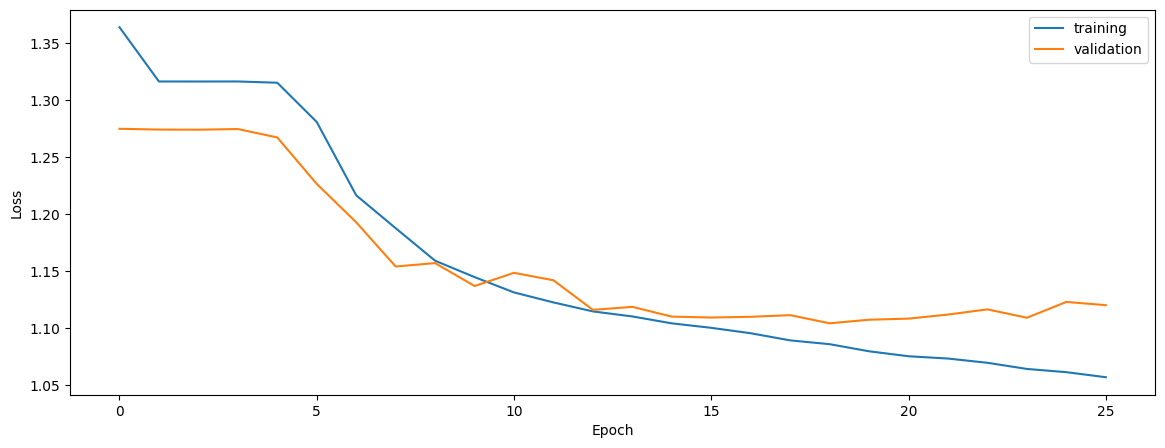

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


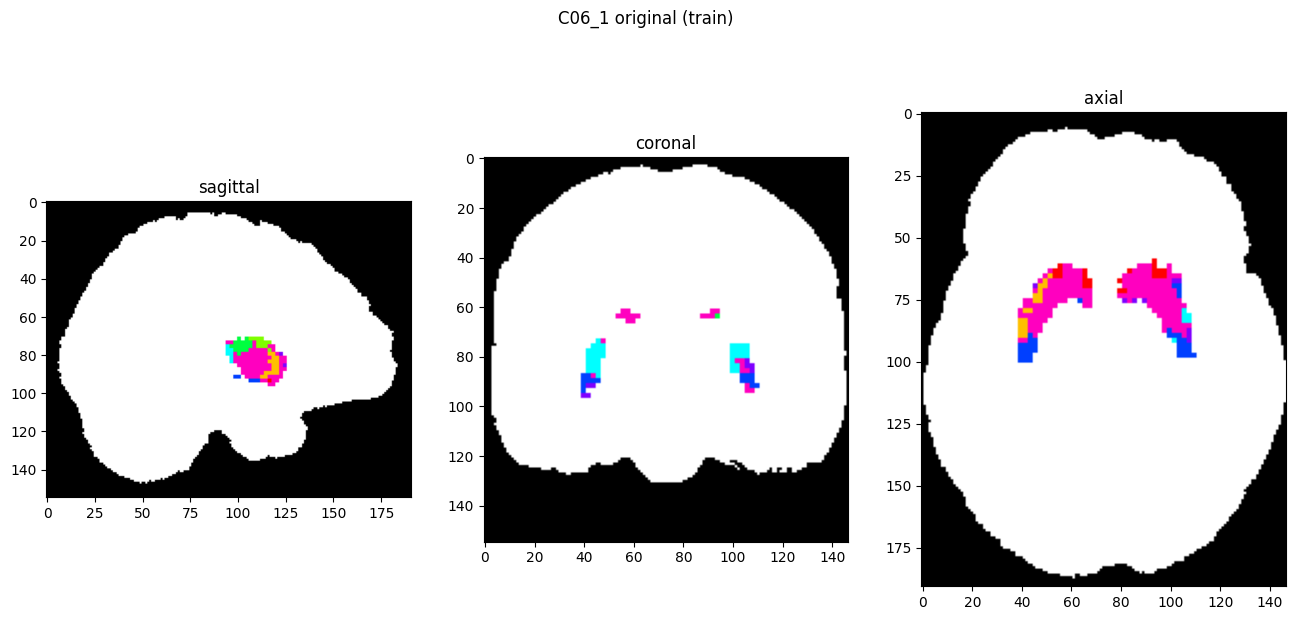

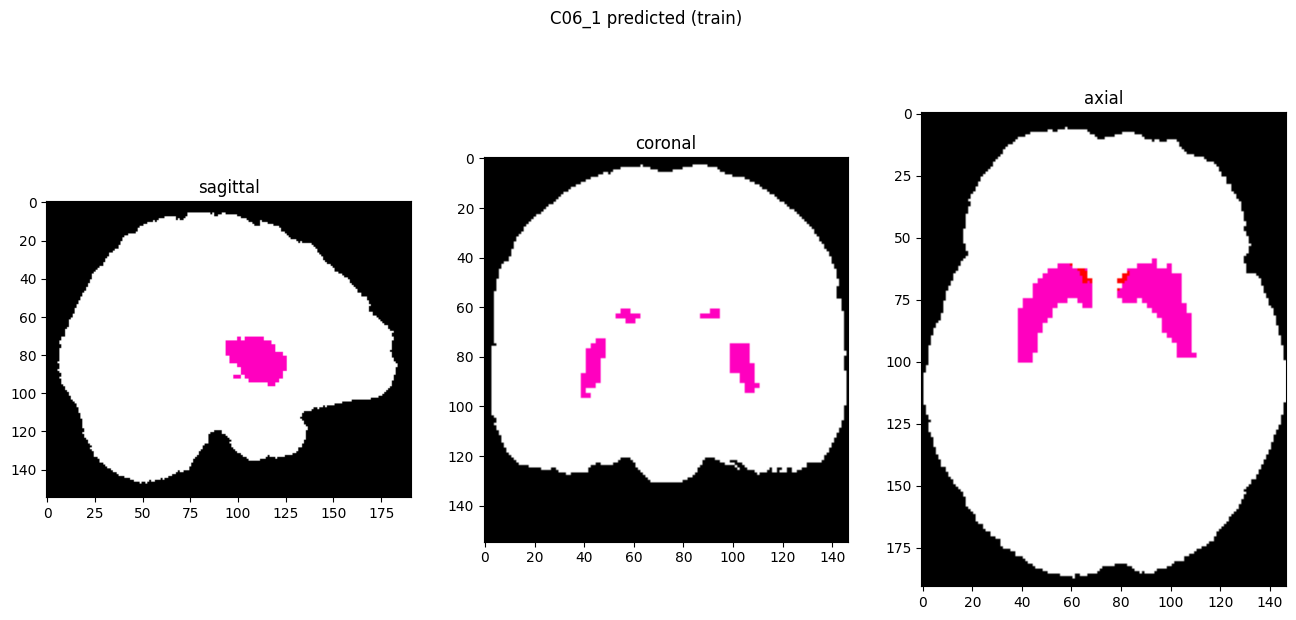

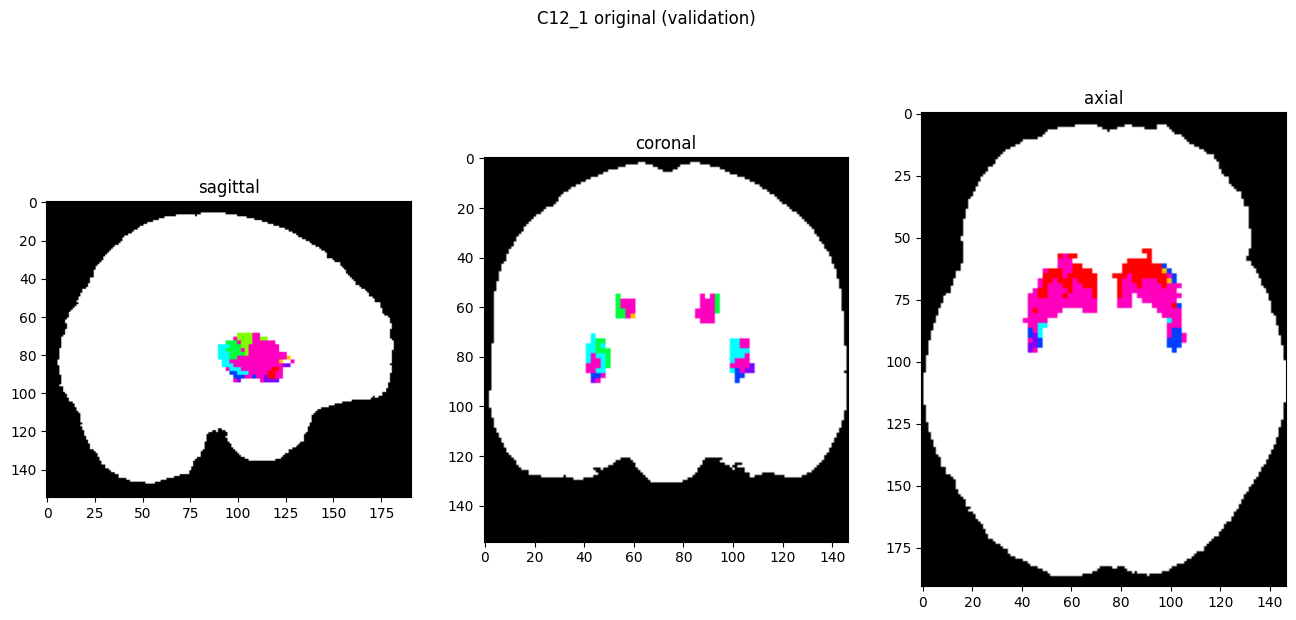

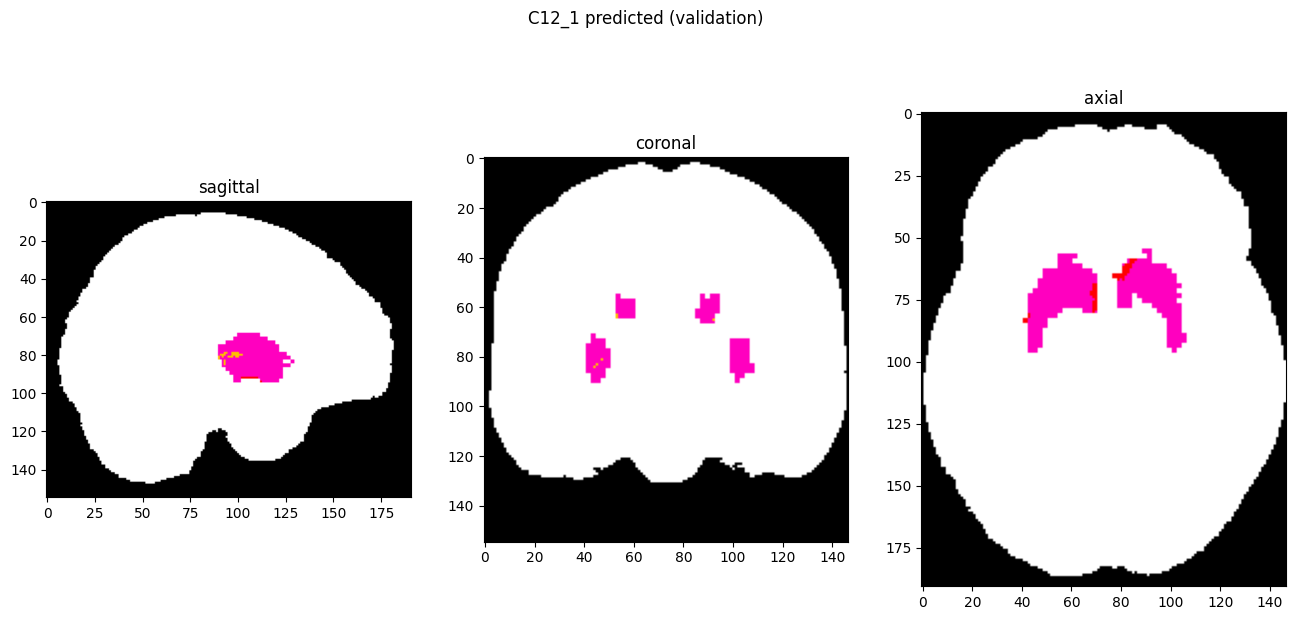

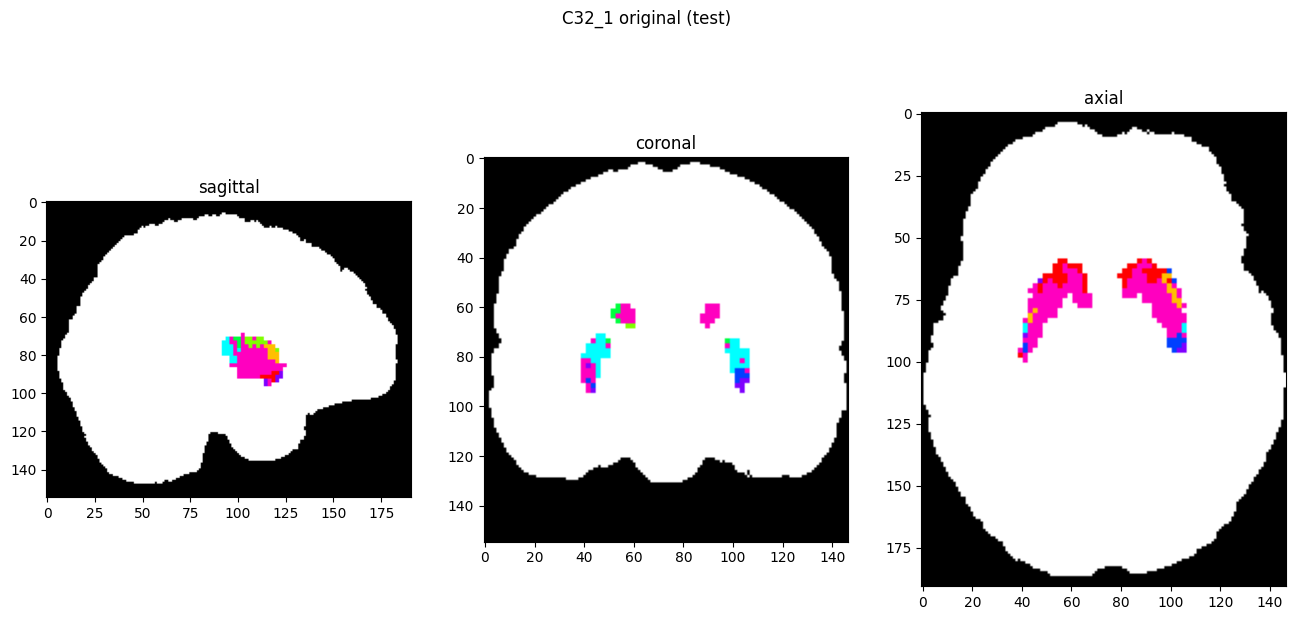

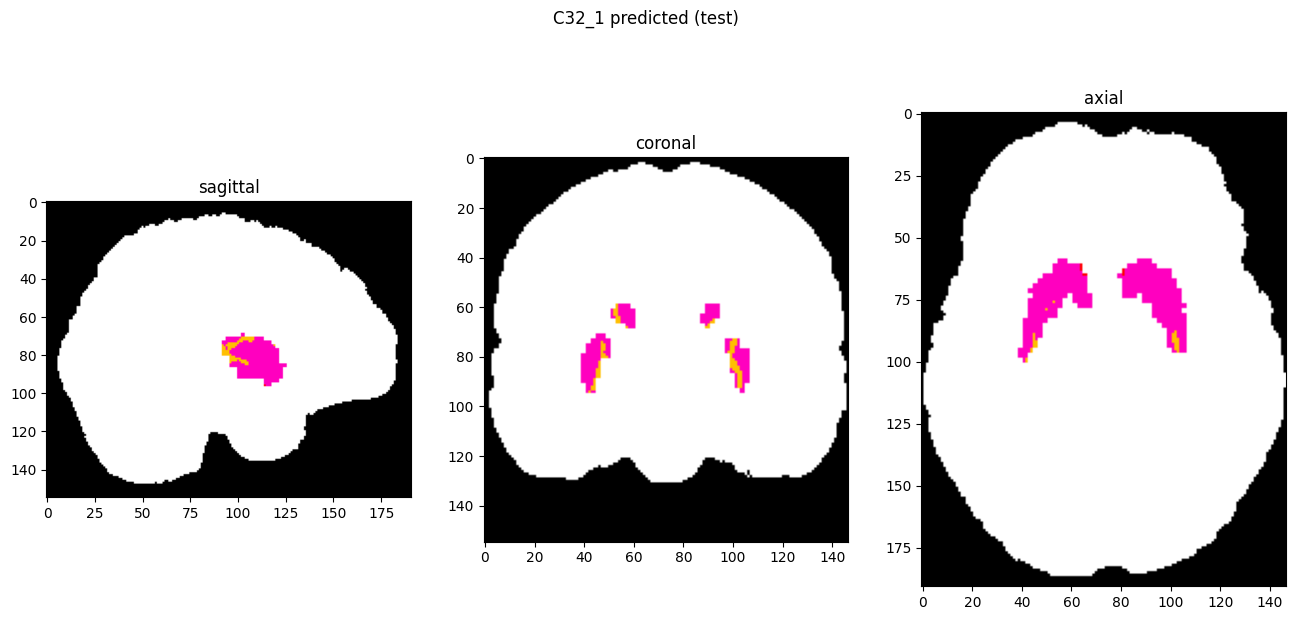

In [10]:
showResults(model, gen, threshold=0)